In [16]:
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from numpy import clip
from torch.autograd import Variable
import torch
from torch import Tensor
from torch.optim import SGD
from IPython.display import clear_output
import ipywidgets as widgets
from ipywidgets import interact
from scipy import special
w = widgets.IntText()
%matplotlib inline
%run utils.py

In [3]:
%load_ext Cython

In [4]:
M, N = (40,140) 

In [58]:
%%cython
import numpy as np
cimport numpy as np

cdef int M, N
M, N = (40,140)

def min_cost(tuple source, tuple target, np.ndarray[float, ndim=2] w):
    cdef int sx, sy, tx, ty, i, j
    sx, sy = source
    tx, ty = target

    cdef int hor_dir, ver_dir
    hor_dir = np.sign(tx - sx)
    ver_dir = np.sign(ty - sy)

    cdef int X, Y
    cdef np.ndarray[double, ndim=2] cost
    cdef np.ndarray[list, ndim=2] paths

    X = np.abs(tx - sx) + 1
    Y = np.abs(ty - sy) + 1
    cost = np.zeros((X, Y))
    paths = np.zeros((X, Y), dtype=object)

    cost[0, 0] = w[sx, sy]
    paths[0, 0] = [source]

    for i in range(1, X):
        cost[i, 0] = cost[i - 1, 0] + w[i * hor_dir + sx, sy]
        paths[i, 0] = paths[i - 1, 0] + [(i * hor_dir + sx, sy)]

    for j in range(1, Y):
        cost[0, j] = cost[0, j - 1] + w[sx, sy + j * ver_dir]
        paths[0, j] = paths[0, j - 1] + [(sx, sy + j * ver_dir)]

    for i in range(1, X):
        for j in range(1, Y):
            if cost[i, j - 1] <= cost[i - 1, j]:
                cost[i, j] = cost[i, j - 1] + \
                    w[sx + i * hor_dir, sy + j * ver_dir]
                paths[i, j] = paths[i, j - 1] + \
                    [(sx + i * hor_dir, sy + j * ver_dir)]
            else:
                cost[i - 1, j] = cost[i - 1, j] + \
                    w[sx + i * hor_dir, sy + j * ver_dir]
                paths[i, j] = paths[i - 1, j] + \
                    [(sx + i * hor_dir, sy + j * ver_dir)]

    cdef np.ndarray st
    st = np.zeros((M,N))

    for i, j in paths[X-1,Y-1]:
        st[i,j] = 1
    return st



In [61]:
def random_path(source, target):
    sx, sy = source
    tx, ty = target
    hor_dir = np.sign(tx - sx)
    ver_dir = np.sign(ty - sy)
    X = np.abs(tx - sx) 
    Y = np.abs(ty - sy) 
    path = np.zeros(X+Y)
    path[:X] = 1
    path = np.random.permutation(path)
    st = np.zeros((M,N))
    st[sx, sy] = 1
    lastx, lasty = sx, sy
    
    for i in path:
        if i == 0:
            lasty += ver_dir
            st[lastx, lasty] = 1
        else:
            lastx += hor_dir
            st[lastx, lasty] = 1
    return st

In [31]:
def unif_path_weights(source, target):
    sx, sy = source
    tx, ty = target
    x_d, y_d = abs(tx-sx), abs(ty-sy)
    
    x, y = np.meshgrid(range(x_d+1), range(y_d+1))
    
    paths1 = special.binom(x+y,x)
    paths2 = special.binom(x_d+y_d-x-y, x_d-x)
    total_paths = special.binom(x_d+y_d,x_d)
    
    small_grid = (paths1 * paths2 / total_paths).T
    
    if (tx-sx)*(ty-sy) < 0:
        small_grid = small_grid[::-1, :]
    
    full_grid = np.zeros((M,N))
    full_grid[min(sx, tx):max(sx,tx)+1, min(sy, ty):max(sy,ty)+1] = small_grid
    
    return full_grid
    
    
    

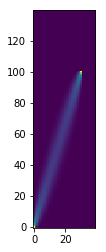

In [41]:
plt.imshow(unif_path_weights((30,100), (0,0)).T, origin='lower')

In [21]:
# chunks = pd.read_csv('data/yellow_tripdata_2009-01_train_JC.csv', chunksize=1000)

In [43]:
# grid = np.load('grid.npy')
# gr = np.zeros((20,70))
# for i, j in grid:
#     gr[int(i), int(j)] = 1.0

weights = Variable((15 * torch.ones((M,N))).float(), requires_grad=True)
optimizer = SGD([weights], lr = 0.0001)

In [44]:
@interact(x=w)
def plot(x):
    plt.figure(figsize=(10,10))
    plt.imshow(torch.nn.functional.softplus(weights).data.numpy().T, 
               clim=(0,50), cmap='bwr', origin='lower')
    plt.savefig('{}.png'.format(x))
    plt.show()
    

interactive(children=(IntText(value=0, description='x'), Output()), _dom_classes=('widget-interact',))

In [ ]:
optimizer = SGD([weights], lr = 0.001)
num_epochs = 5
with tqdm(total=num_epochs * 8030 * 1000) as pbar:
    for epoch in range(num_epochs):
        chunks = pd.read_csv('data/yellow_tripdata_2009-01_train_JC.csv', 
                             chunksize=10000)
        total_loss, n = 0, 0
        for df in chunks:
            for _, row in df.iterrows():
                pbar.update(1)
                source = (int(clip(round(M/10 * row['start_x']), 0, M-1)), 
                          int(clip(round(M/10 * row['start_y']), 0, N-1)))
                target = (int(clip(round(M/10 * row['end_x']), 0, M-1)), 
                          int(clip(round(M/10 * row['end_y']), 0, N-1)))
                
                path = unif_path_weights(source, target)
                pred = (Variable(Tensor(path)) 
                        * torch.nn.functional.softplus(weights)).sum()
                loss = (pred - row['duration']) ** 2
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += np.sqrt(loss.data[0])
                n += 1
                if pbar.n % 2000 == 0:
                    print(total_loss/n/60)
                    w.value += 1
                    clear_output(wait=True)

In [417]:
# torch.save(weights, 'weights_4x_min_cost.pt')

In [49]:
weights

Variable containing:
  18.2937   15.2162   15.9050  ...    15.0000   15.0000   15.0000
  16.5694   15.2121   15.2728  ...    15.0000   15.0000   15.0000
  15.5406   14.5234   14.7567  ...    15.0000   15.0000   15.0000
             ...                ⋱                ...             
  15.0000   15.0000   15.0000  ...    14.1062   91.7242  131.6433
  15.0000   15.0000   15.0000  ...    10.0105  116.4045   56.7057
  15.0000   15.0000   15.0000  ...   139.4594  143.5306  145.2057
[torch.FloatTensor of size 40x140]

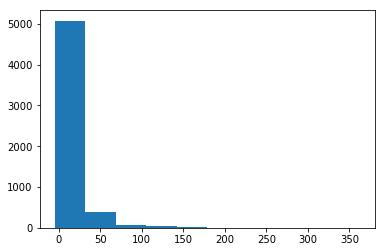

In [52]:
plt.hist((weights.data.numpy()[~np.isnan(weights.data.numpy())]));

In [185]:
test = pd.read_csv('data/yellow_tripdata_2009-01_test_JC.csv')

In [194]:
np.percentile(test['duration'],99.99)/60

1142.0